In [4]:
# Figure S6 plotter
# Copyright Jackson M. Tsuji, Neufeld Research Group, 2020

In [2]:
import pandas as pd
import re
from plotnine import *

In [26]:
# User variables
fegenie_naming_data_filepath = 'fegenie_naming.tsv'
hmm_naming_data_filepath = 'S_cycling_hmm_naming.tsv'
fegenie_data_filepath = '../input_data/FeGenie-geneSummary.csv'
hmmsearch_data_filepath = '../input_data/S_cycling_hmm_search_results_raw.tsv'
read_mapping_data_filepath = '../../Figure_03_environmental_abundances/input_data/genome_bin_mapping_stats.tsv'
assembled_read_data_filepath = '../../Figure_03_environmental_abundances/input_data/assembled_read_stats.tsv'
checkm_data_filepath = '../../Figure_03_environmental_abundances/input_data/checkm_stats_reduced.tsv'
gtdb_taxonomy_bacteria_data_filepath = '../../Figure_03_environmental_abundances/input_data/ELA111314_dRep_gtdbtk.bac120.summary.tsv'
gtdb_taxonomy_archaea_data_filepath = '../../Figure_03_environmental_abundances/input_data/ELA111314_dRep_gtdbtk.ar122.summary.tsv'
genome_naming_data_filepath = '../../Figure_03_environmental_abundances/input_data/genome_naming_info.tsv'
output_heatmap_pdf_filepath = 'Figure_S6a_raw.pdf'
output_bubbleplot_pdf_filepath = 'Figure_S6b_raw.pdf'

In [5]:
# Function to parse a single GTDBTk taxonomy entry
def parse_gtdbtk_taxonomy_entry(taxonomy_entry, resolve = True):
    # EXAMPLE: 'd__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Microtrichales;f__;g__;s__'
    
    taxonomy_split = str(taxonomy_entry).split(sep = ';')
    if len(taxonomy_split) != 7:
        logger.error('Taxonomy entry is ' + str(len(taxonomy_split)) + ' long, not 7 as expected. Exiting...')
        loger.error('Entry was: ' + ', '.join(taxonomy_entry))
        sys.exit(1)

    # Remove header pieces
    # TODO - confirm they are in the right order (d, p, c, o, f, g, s)
    taxonomy_split = [ re.sub("[dpcofgs]__", "", level) for level in taxonomy_split ]

    # Fill in empty parts, if they exist
    if '' in taxonomy_split and resolve is True:
        # Get the positions of the empty spots
        empty_taxa = []
        for taxonomy_level in taxonomy_split:
            if taxonomy_level == '':
                empty_taxa.append(True)
            else:
                empty_taxa.append(False)

        # Get the numeric index of the first empty taxon
        # See https://stackoverflow.com/a/9542768, accessed Sept. 18, 2019
        first_empty_taxon = empty_taxa.index(True)

        if False in empty_taxa[first_empty_taxon:]:
            logger.error('There seems to be an empty entry in the middle of your taxonomy levels. Cannot resolve. Exiting...')
            logger.error('Entry was: ' + ', '.join(taxonomy_entry))
            sys.exit(1)

        filler_entry = 'Unresolved_' + taxonomy_split[(first_empty_taxon-1)]

        for taxonomy_level_index in range(first_empty_taxon, 7):
            taxonomy_split[taxonomy_level_index] = filler_entry

    return(taxonomy_split)

In [7]:
# Load FeGenie naming info
fegenie_naming_data = pd.read_csv(fegenie_naming_data_filepath, sep='\t')
fegenie_naming_data.head()

,raw_name,new_name
0,Cyc2_repCluster1,cyc2_group1
1,Cyc1,cyc1
2,Cyc2_repCluster2,cyc2_group2
3,Cyc2_repCluster3,cyc2_group3
4,CymA,cymA


In [8]:
# Load FeGenie data - get rid of duplicate first row (bug in this version of FeGenie)
fegenie_data = pd.read_csv(fegenie_data_filepath, sep=',')[1:]
fegenie_data = fegenie_data.rename(columns={'genome/assembly':'genome'}).drop(columns='protein_sequence')
fegenie_data['genome'] = fegenie_data['genome'].str.replace('.fa', '').str.replace('-', '_').str.replace('.','_')
fegenie_data['genome'] = fegenie_data['genome'].replace(genome_naming_data['raw_name'].to_list(), 
                                                        genome_naming_data['new_name'].to_list())
fegenie_data = fegenie_data[fegenie_data['category'].isin(['iron_oxidation', 'iron_reduction'])]

fegenie_data['HMM'] = fegenie_data['HMM'].replace(fegenie_naming_data['raw_name'].to_list(), 
                                                  fegenie_naming_data['new_name'].to_list())
fegenie_data.head()

,category,genome,orf,HMM,bitscore,bitscore_cutoff,clusterID,heme_binding_motifs
61,iron_oxidation,L227 2014 Bin 92,CA-L227-2014_64247_2,cyc2_group1,134.2,31.5,61,1
62,iron_oxidation,L227 2014 Bin 92,CA-L227-2014_238212_3,cyc2_group1,128.9,31.5,62,1
63,iron_oxidation,L227 2014 Bin 92,CA-L227-2014_161657_1,cyc2_group3,60.6,27.3,63,1
115,iron_oxidation,L442 Bin 2,CA-L442_255164_3,cyc2_group2,280.5,27.8,137,1
116,iron_oxidation,L442 Bin 2,CA-L442_255164_4,cyc1,184.2,98,137,2


In [9]:
# Load S-cycling HMM naming info
hmm_naming_data = pd.read_csv(hmm_naming_data_filepath, sep='\t')
hmm_naming_data.head()

,raw_name,new_name
0,TIGR02061,aprA
1,TIGR02060,aprB
2,dsrA,dsrA
3,dsrB,dsrB
4,soxB,soxB


In [10]:
# Load S-cycling HMM search results
hmmsearch_data = pd.read_csv(hmmsearch_data_filepath, sep='\t')
hmmsearch_data['genome'] = hmmsearch_data['genome'].replace(genome_naming_data['raw_name'].to_list(), 
                                                            genome_naming_data['new_name'].to_list())
hmmsearch_data['hmm_id'] = hmmsearch_data['hmm_id'].replace(hmm_naming_data['raw_name'].to_list(), 
                                                            hmm_naming_data['new_name'].to_list())
hmmsearch_data.head()

,genome,orf_id,hmm_id,evalue,score,bias
0,L227 2014 Bin 106,CA-L227-2014_20263_9,dsrA,3.000000e-123,409.4,0.2
1,L227 2014 Bin 106,CA-L227-2014_8235_13,dsrA,3.400000e-123,409.2,0.2
2,L227 2014 Bin 106,CA-L227-2014_8235_12,dsrB,1.800000e-132,440.1,0.7
3,L227 2014 Bin 106,CA-L227-2014_20263_10,dsrB,2.000000e-130,433.4,0.7
4,L227 2014 Bin 24,CA-L227-2014_135356_4,dsrA,1.900000e-175,580.7,0.5


In [6]:
# Load genome naming data
genome_naming_data = pd.read_csv(genome_naming_data_filepath, sep='\t')
genome_naming_data.head()

,raw_name,new_name
0,CA_L227_2013_13,L227 2013 Bin 13
1,CA_L227_2013_15,L227 2013 Bin 15
2,CA_L227_2013_18,L227 2013 Bin 18
3,L227_2013_bin22,L227 2013 Bin 22
4,CA_L227_2013_23,L227 2013 Bin 23


In [11]:
# Load CheckM data
checkm_data = pd.read_csv(checkm_data_filepath, sep='\t')
checkm_data.drop(columns=['taxonomy_contained', 'taxonomy_sister_lineage'], inplace=True)
checkm_data['genome'] = checkm_data['genome'].str.replace('.fasta', '', regex=False, n=1)
checkm_data['genome'] = checkm_data['genome'].str.replace('-', '_').str.replace('.','_')
checkm_data['genome'] = checkm_data['genome'].replace(genome_naming_data['raw_name'].to_list(), 
                                                      genome_naming_data['new_name'].to_list())
checkm_data.head()

,genome,completeness,contamination,strain_heterogeneity
0,CA_L442_1,59.31,1.80,0.00
1,CA_L442_10,53.53,2.21,14.29
2,CA_L442_11,0.00,0.00,0.00
3,L442 Bin 12,89.34,18.53,10.00
4,CA_L442_13,64.58,8.55,17.39


In [12]:
# Load GTDB taxonomy data
gtdb_taxonomy_bacteria_data = pd.read_csv(gtdb_taxonomy_bacteria_data_filepath, sep='\t')
gtdb_taxonomy_archaea_data = pd.read_csv(gtdb_taxonomy_archaea_data_filepath, sep='\t')
gtdb_taxonomy_data = gtdb_taxonomy_bacteria_data.append(gtdb_taxonomy_archaea_data)
gtdb_taxonomy_data = gtdb_taxonomy_data[['user_genome', 'classification']]
gtdb_taxonomy_data.rename(columns={'user_genome': 'genome'}, inplace=True)
gtdb_taxonomy_data['genome'] = gtdb_taxonomy_data['genome'].str.replace('-', '_').str.replace('.','_')
gtdb_taxonomy_data['genome'] = gtdb_taxonomy_data['genome'].replace(genome_naming_data['raw_name'].to_list(), 
                                                                    genome_naming_data['new_name'].to_list())

# Parse taxonomy
taxonomy_entries_parsed = map(lambda entry: parse_gtdbtk_taxonomy_entry(entry, resolve = True), 
                              gtdb_taxonomy_data['classification'].tolist())
taxonomy_table_parsed = pd.DataFrame(taxonomy_entries_parsed, 
                              columns = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'])

# Add genome column
taxonomy_table_parsed.insert(loc = 0, column = 'genome', value = gtdb_taxonomy_data['genome'].tolist())
taxonomy_table_parsed.head()

,genome,domain,phylum,class,order,family,genus,species
0,L442 2011 16.5m Bin 3,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Gallionellaceae,UBA7399,GCA_002470125.1
1,L442 Bin 82,Bacteria,Chloroflexota,Chloroflexia,Chloroflexales,Chloroflexaceae,Oscillochloris,Unresolved_Oscillochloris
2,L227 2013 Bin 64,Bacteria,Patescibacteria,Paceibacteria,UBA9983,GWA1-40-21,Unresolved_GWA1-40-21,Unresolved_GWA1-40-21
3,L227 2014 6m Bin 15,Bacteria,Patescibacteria,ABY1,Falkowbacterales,UBA12465,Unresolved_UBA12465,Unresolved_UBA12465
4,L442 Bin 33,Bacteria,Actinobacteriota,Acidimicrobiia,Acidimicrobiales,RAAP-2,Unresolved_RAAP-2,Unresolved_RAAP-2


In [13]:
# Combine Fe and S data into a single table
# Fe 
Fe_data = fegenie_data.rename(columns={'HMM': 'hmm_id', 'orf': 'orf_id'})\
.drop(columns=['category', 'bitscore', 'bitscore_cutoff', 
               'clusterID', 'heme_binding_motifs'])
Fe_data['element'] = 'Fe'

# S
S_data = hmmsearch_data.drop(columns=['evalue', 'score', 'bias'])
S_data['element'] = 'S'

Fe_S_data_combined = Fe_data.append(S_data, ignore_index=True)
Fe_S_data_combined.head()

,genome,orf_id,hmm_id,element
0,L227 2014 Bin 92,CA-L227-2014_64247_2,cyc2_group1,Fe
1,L227 2014 Bin 92,CA-L227-2014_238212_3,cyc2_group1,Fe
2,L227 2014 Bin 92,CA-L227-2014_161657_1,cyc2_group3,Fe
3,L442 Bin 2,CA-L442_255164_3,cyc2_group2,Fe
4,L442 Bin 2,CA-L442_255164_4,cyc1,Fe


In [88]:
# Also get the combined naming data
tmp = Fe_S_data_combined.rename(columns={'hmm_id': 'new_name'})
Fe_S_naming_data = fegenie_naming_data.append(hmm_naming_data, ignore_index=True)\
                   .merge(tmp[['new_name','element']], on='new_name', how='left')\
                   .drop_duplicates()
Fe_S_naming_data.head()

,raw_name,new_name,element
0,Cyc2_repCluster1,cyc2_group1,Fe
6,Cyc1,cyc1,Fe
9,Cyc2_repCluster2,cyc2_group2,Fe
25,Cyc2_repCluster3,cyc2_group3,Fe
41,CymA,cymA,Fe


In [109]:
# Combine info
# Quick transformation to get black outlines on all boxes - a bit hacky
plotting_data = Fe_S_data_combined[['genome','hmm_id']].groupby(['genome', 'hmm_id']).size()\
  .reset_index()\
  .rename(columns={0:'count'})\
  .pivot(index='genome', columns='hmm_id', values='count')\
  .fillna(value=0)\
  .rename(columns=str)\
  .reset_index()\
  .melt(id_vars='genome', value_name='count')

plotting_data['present'] = plotting_data['count'] > 0

plotting_data = plotting_data.merge(Fe_S_naming_data[['new_name','element']].rename(columns={'new_name': 'hmm_id'}), on='hmm_id', how='left')\
                            .merge(checkm_data, on='genome', how='left')\
                            .merge(taxonomy_table_parsed, on='genome', how='left')

plotting_data.head()

,genome,hmm_id,count,present,element,completeness,contamination,strain_heterogeneity,domain,phylum,class,order,family,genus,species
0,L227 2013 8m Bin 1,A. dehalogenans PCC-1,0.0,False,Fe,95.74,1.61,25.0,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylomonadaceae,KS41,Unresolved_KS41
1,L227 2013 Bin 22,A. dehalogenans PCC-1,0.0,False,Fe,98.50,2.75,0.0,Bacteria,Bacteroidota,Chlorobia,Chlorobiales,Chlorobiaceae,Chlorobium,Unresolved_Chlorobium
2,L227 2013 Bin 55,A. dehalogenans PCC-1,0.0,False,Fe,97.39,0.11,0.0,Bacteria,Bacteroidota,Chlorobia,Chlorobiales,Chlorobiaceae,Chlorobium,Unresolved_Chlorobium
3,L227 2013 Bin 56,A. dehalogenans PCC-1,0.0,False,Fe,96.70,0.57,0.0,Bacteria,Bacteroidota,Chlorobia,Chlorobiales,Chlorobiaceae,Chlorobium,Unresolved_Chlorobium
4,L227 2014 6m Bin 13,A. dehalogenans PCC-1,0.0,False,Fe,93.71,1.10,20.0,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylomonadaceae,UBA10906,Unresolved_UBA10906


In [110]:
# Classify genomes based on Fe vs. S gene content
# LOGIC:
# Fe_S genomes have both Fe and S genes
# Fe genomes have only Fe genes
# S genomes have only S genes
genome_content = plotting_data[plotting_data['count'] > 0].groupby(['genome', 'element'])\
.size().reset_index()\
.rename(columns={0:'count'})\
.pivot(index='genome', columns='element', values='count')\
.fillna(value=0)\
.reset_index()

Fe_S_status = []
for index,row in genome_content.iterrows():
    genome_id=row['genome']
    n_Fe_genes=row['Fe']
    n_S_genes=row['S']
    
    if (n_Fe_genes > 0) & (n_S_genes == 0):
        Fe_S_status.append('1Fe')
    elif (n_Fe_genes == 0) & (n_S_genes > 0):
        Fe_S_status.append('2S')
    elif (n_Fe_genes > 0) & (n_S_genes > 0):
        Fe_S_status.append('0Fe_S')
    elif (n_Fe_genes == 0) & (n_S_genes == 0):
        print('ERROR:', genome_id, ': no Fe or S genes!')
    else:
        print('ERROR:', genome_id, ': are there negative or non-numeric gene counts?')

genome_content['Fe_S_status'] = Fe_S_status
genome_content.head()

element,genome,Fe,S,Fe_S_status
0,L227 2013 8m Bin 1,1.0,0.0,1Fe
1,L227 2013 Bin 22,1.0,0.0,1Fe
2,L227 2013 Bin 55,1.0,2.0,0Fe_S
3,L227 2013 Bin 56,2.0,0.0,1Fe
4,L227 2014 6m Bin 13,1.0,0.0,1Fe


In [111]:
# Add Fe_S_status to plotting data and sort
plotting_data_with_status = plotting_data.merge(genome_content[['genome', 'Fe_S_status']], on='genome', how='left')

# Rename things for final plot
plotting_data_with_status['plotting_label'] = plotting_data_with_status['genome'] + ' (' + \
                                  plotting_data_with_status['completeness'].apply(str) + '/' + \
                                  plotting_data_with_status['contamination'].apply(str) + '/' + \
                                  plotting_data_with_status['strain_heterogeneity'].apply(str) +')' + \
                                  ' f__' + plotting_data_with_status['family'] + \
                                  '; g__' + plotting_data_with_status['genus']

# Make ordered factors for sorting x and y axes on plot
hmm_sorting = Fe_S_naming_data[Fe_S_naming_data['new_name'].isin(plotting_data_with_status['hmm_id'].unique())]
plotting_data_with_status['hmm_id'] = pd.Categorical(plotting_data_with_status['hmm_id'], 
                                                     categories = hmm_sorting['new_name'], ordered=True)

sorting = taxonomy_table_parsed.merge(plotting_data_with_status[['genome','plotting_label','Fe_S_status']], how='right', on='genome')\
            .drop_duplicates()\
            .sort_values(by=['Fe_S_status','domain','phylum','class','order','family','genus','species','genome'])
plotting_data_with_status['plotting_label'] = pd.Categorical(plotting_data_with_status['plotting_label'], 
                                                             categories = sorting['plotting_label'][::-1], ordered=True)

plotting_data_with_status.head()

,genome,hmm_id,count,present,element,completeness,contamination,strain_heterogeneity,domain,phylum,class,order,family,genus,species,Fe_S_status,plotting_label
0,L227 2013 8m Bin 1,A. dehalogenans PCC-1,0.0,False,Fe,95.74,1.61,25.0,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylomonadaceae,KS41,Unresolved_KS41,1Fe,L227 2013 8m Bin 1 (95.74/1.61/25.0) f__Methyl...
1,L227 2013 Bin 22,A. dehalogenans PCC-1,0.0,False,Fe,98.50,2.75,0.0,Bacteria,Bacteroidota,Chlorobia,Chlorobiales,Chlorobiaceae,Chlorobium,Unresolved_Chlorobium,1Fe,L227 2013 Bin 22 (98.5/2.75/0.0) f__Chlorobiac...
2,L227 2013 Bin 55,A. dehalogenans PCC-1,0.0,False,Fe,97.39,0.11,0.0,Bacteria,Bacteroidota,Chlorobia,Chlorobiales,Chlorobiaceae,Chlorobium,Unresolved_Chlorobium,0Fe_S,L227 2013 Bin 55 (97.39/0.11/0.0) f__Chlorobia...
3,L227 2013 Bin 56,A. dehalogenans PCC-1,0.0,False,Fe,96.70,0.57,0.0,Bacteria,Bacteroidota,Chlorobia,Chlorobiales,Chlorobiaceae,Chlorobium,Unresolved_Chlorobium,1Fe,L227 2013 Bin 56 (96.7/0.57/0.0) f__Chlorobiac...
4,L227 2014 6m Bin 13,A. dehalogenans PCC-1,0.0,False,Fe,93.71,1.10,20.0,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylomonadaceae,UBA10906,Unresolved_UBA10906,1Fe,L227 2014 6m Bin 13 (93.71/1.1/20.0) f__Methyl...


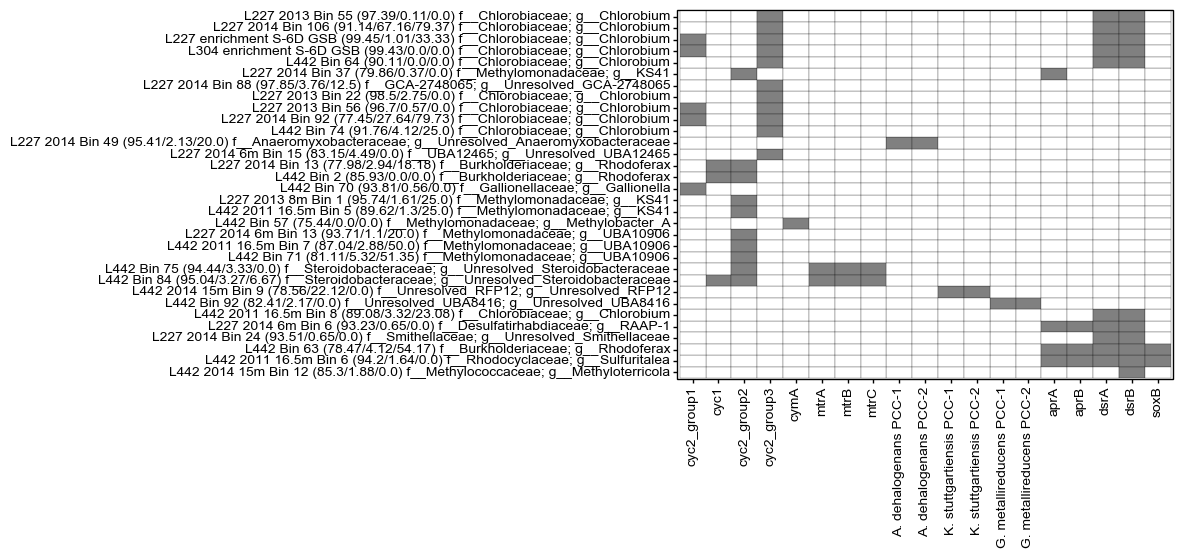

<ggplot: (-9223363283190358240)>


In [117]:
# Plot
heatmap_plot = (ggplot(plotting_data_with_status, aes(x='hmm_id', y='plotting_label'))
 + geom_tile(aes(fill='present'), colour='black')
# +  geom_tile(aes(fill='element'), colour='black', size=0.5)
#+ geom_text(aes(label='evalue'), size=5)
# + scale_size_continuous(range = [3,40])
 + scale_fill_manual(values=['white','grey'])
 + guides(fill=False)
 + theme_bw()
 + theme(text = element_text(family='arial', colour='black'), axis_title = element_blank(), 
         axis_text = element_text(size=10), panel_grid=element_blank(),
         axis_text_x = element_text(angle=90, vjust=1, hjust=0.5), 
         panel_border = element_rect(colour='black'),
         legend_text = element_text(size=10), 
         legend_title = element_text(size=10, face="bold"))
)
print(heatmap_plot)

In [19]:
# Load read mapping data
read_mapping_data = pd.read_csv(read_mapping_data_filepath, sep='\t')
read_mapping_data.drop(columns=['coverage_mean', 'coverage_sd', 'genome_length_bp', 'genome_num_contigs'], inplace=True)
assembled_read_data = pd.read_csv(assembled_read_data_filepath, sep='\t')
read_mapping_data = read_mapping_data.merge(assembled_read_data, on='metagenome', how='left')
read_mapping_data['perc_mapped_assembled_reads'] = read_mapping_data['mapped_reads'] / read_mapping_data['mapped_assembled_reads'] * 100

read_mapping_data['genome'] = read_mapping_data['genome'].str.replace('-', '_').str.replace('.','_')
read_mapping_data['genome'] = read_mapping_data['genome'].replace(genome_naming_data['raw_name'].to_list(), 
                                                                  genome_naming_data['new_name'].to_list())

# Filter to genomes of interest
genomes_of_interest = plotting_data_with_status['genome'].unique().tolist()
read_mapping_data = read_mapping_data[read_mapping_data['genome'].isin(genomes_of_interest)]

read_mapping_data.head()

In [127]:
# Make bubble plotting data
bubble_plotting_data = read_mapping_data.merge(plotting_data_with_status, on='genome', how='left')\
.drop(columns=['count','present','hmm_id','element']).drop_duplicates()

# Rename things for final plot
bubble_plotting_data['perc_mapped_assembled_rounded'] = round(bubble_plotting_data['perc_mapped_assembled_reads'], 1)
bubble_plotting_data['metagenome'] = pd.Categorical(bubble_plotting_data['metagenome'], 
                                                    categories = assembled_read_data['metagenome'], ordered=True)

# Filter out individual entries with < 0.05% relative abundance for clarity of plot
bubble_plotting_data = bubble_plotting_data[bubble_plotting_data['perc_mapped_assembled_reads'] >= 0.05]
bubble_plotting_data.head()

,genome,metagenome,mapped_reads,metagenome_total_reads,mapped_assembled_reads,perc_mapped_assembled_reads,completeness,contamination,strain_heterogeneity,domain,phylum,class,order,family,genus,species,Fe_S_status,plotting_label,perc_mapped_assembled_rounded
133,L442 Bin 92,L442-2014-15m,159404,54406863,19177614,0.831198,82.41,2.17,0.0,Bacteria,Verrucomicrobiota,Kiritimatiellae,UBA8416,Unresolved_UBA8416,Unresolved_UBA8416,Unresolved_UBA8416,1Fe,L442 Bin 92 (82.41/2.17/0.0) f__Unresolved_UBA...,0.8
209,L442 Bin 92,L442-2011-16-5m,13382,61146180,20511862,0.065240,82.41,2.17,0.0,Bacteria,Verrucomicrobiota,Kiritimatiellae,UBA8416,Unresolved_UBA8416,Unresolved_UBA8416,Unresolved_UBA8416,1Fe,L442 Bin 92 (82.41/2.17/0.0) f__Unresolved_UBA...,0.1
342,L227 2014 6m Bin 13,L227-2013-6m,985578,53941731,25143763,3.919771,93.71,1.10,20.0,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylomonadaceae,UBA10906,Unresolved_UBA10906,1Fe,L227 2014 6m Bin 13 (93.71/1.1/20.0) f__Methyl...,3.9
380,L227 2014 6m Bin 13,L227-2013-8m,80983,53941011,17479583,0.463301,93.71,1.10,20.0,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylomonadaceae,UBA10906,Unresolved_UBA10906,1Fe,L227 2014 6m Bin 13 (93.71/1.1/20.0) f__Methyl...,0.5
399,L227 2014 6m Bin 13,L227-2014-8m,107392,51774711,15130865,0.709755,93.71,1.10,20.0,Bacteria,Proteobacteria,Gammaproteobacteria,Methylococcales,Methylomonadaceae,UBA10906,Unresolved_UBA10906,1Fe,L227 2014 6m Bin 13 (93.71/1.1/20.0) f__Methyl...,0.7


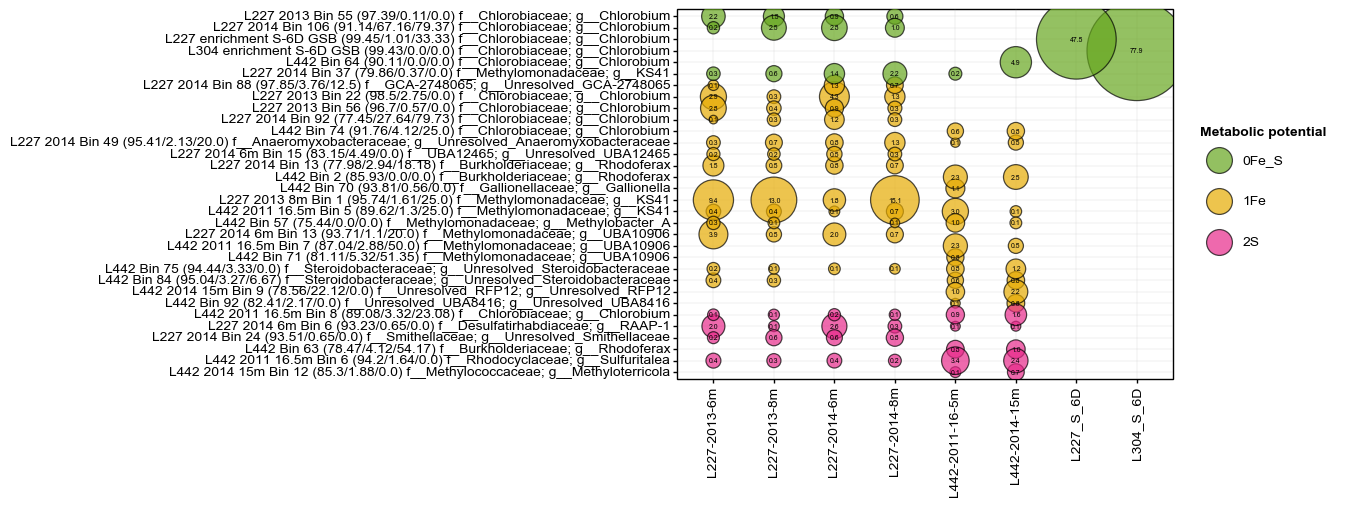

<ggplot: (-9223363283193031203)>


In [128]:
# Plot
bubble_plot = (ggplot(bubble_plotting_data, aes(x='metagenome', y='plotting_label'))
 + geom_point(aes(size='perc_mapped_assembled_reads', fill='Fe_S_status'), 
              alpha=0.7, colour="black")
 + geom_text(aes(label='perc_mapped_assembled_rounded'), size=5)
 + scale_size_continuous(range = [3,40])
 + scale_fill_manual(values=['#66a61e', '#e6ab02', '#e7298a'])
 + guides(size=False, fill = guide_legend(title='Metabolic potential', override_aes = {'size': 10}))
 + theme_bw()
 + theme(text = element_text(family='arial', colour='black'), axis_title = element_blank(), 
         axis_text = element_text(size=10), 
         axis_text_x = element_text(angle=90, vjust=1, hjust=0.5), 
         panel_border = element_rect(colour='black'),
         panel_grid = element_line(colour = "#999999", size = 0.1),
         legend_text = element_text(size=10), 
         legend_title = element_text(size=10, face="bold"),
         legend_key = element_blank())
)
print(bubble_plot)

In [129]:
heatmap_plot.save(output_heatmap_pdf_filepath, width=130, height=200, units='mm')
bubble_plot.save(output_bubbleplot_pdf_filepath, width=110, height=200, units='mm')

/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 130.00000000000003 x 200.0 mm image.
  from_inches(height, units), units), PlotnineWarning)
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_S7a_vs4_raw.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 110.00000000000001 x 200.0 mm image.
  from_inches(height, units), units), PlotnineWarning)
/Analysis/jmtsuji/miniconda3_mellea/envs/jupyterlab/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_S7b_vs4_raw.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
